# Zajęcia 2 - drzewa decyzyjne

Uwaga dla fanów Windowsa (takich jak ja): będzie potrzebna biblioteka Graphviz, którą trzeba zainstalować, a następnie do poniższego stringa wkleić adres folderu "bin" z folderu instalacji Graphviza.  

Uwaga dla wszystkich: jeżeli będziecie dostawali błędy typu "brak modułu Graphviz", to trzeba go zainstalować do Anacondy, np. poprzez `conda install graphviz` lub `pip install graphviz`. Na Windowsie to drugie uruchomione w Anaconda Powershell Prompt działa na pewno (sam testowałem).

In [2]:
graphviz_path = r'C:\Program Files (x86)\Graphviz2.38\bin'

## Ładowanie danych

Załadujemy zbiór danych Breast Cancer Wisconsin, na którym pracowaliśmy już ostatnio. Podzielimy go też od razu na zbiór treningowy i zbiór testowy.

In [3]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [4]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

## Wykorzystanie gotowego klasyfikatora

Wykorzystamy teraz gotowy klasyfikator ze Scikit-learn'a z domyślnymi parametrami, aby dokonać predykcji na powyższym zbiorze danych.

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train,y_train)
print(tree_model)  # print parameters
y_tree_pred = tree_model.predict(X_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Powyżej można zaobserwować parametry klasyfikatora, w większości związane ze sposobem pre-pruningu drzewa (który domyślnie właściwie nie istnieje, dużo None'ów). Dokładne ich znaczenie można znaleźć w dokumentacji, ale po nazwach można się raczej domyślić, że o wielu z nich mówiliśmy na zajęciach.  

Dla porównania przypomnimy sobie także, jak na tym zbiorze radzi sobie kNN.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_knn_pred = knn_model.predict(X_test)

Dla porównania przypomnimy sobie także, jak na tym zbiorze radzi sobie kNN. Do pomiaru jakości wykorzystamy wbudowaną funkcję `classification_raport()`, która policzy nam wszystkie główne metryki. Liczy je ona zarówno dla poszczególnych klas, jak i niektóre wyniki zagregowane dla całości. W szczególności ciekawy jest wiersz "weighted avg", który przypisuje wagę proporcjonalną do rzadkości klasy, więc poprawne przewidywanie rzadszych klas jest "cenniejsze".

In [12]:
from sklearn.metrics import classification_report

print("Decision tree results:")
print(classification_report(y_test, y_tree_pred))

print("kNN predictions:")
print(classification_report(y_test, y_knn_pred))

Decision tree results:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89        53
           1       0.98      0.88      0.92        90

    accuracy                           0.91       143
   macro avg       0.90      0.92      0.91       143
weighted avg       0.92      0.91      0.91       143

kNN predictions:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        53
           1       0.96      0.94      0.95        90

    accuracy                           0.94       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143



Jak widać, kNN jest po prostu lepszy, zmarnowaliśmy czas na tych zajęciach. A może widać tu po prostu pewną typową własność drzew... overfitting? Spróbujmy uśrednić wyniki za pomocą walidacji skrośnej, żeby zyskać trochę bardziej miarodajne wyniki.

In [7]:
from sklearn.model_selection import cross_val_score

tree_avg_score = cross_val_score(estimator=tree_model, X=X_test, y=y_test, cv=10, scoring='accuracy').mean()
knn_avg_score = cross_val_score(estimator=knn_model, X=X_test, y=y_test, cv=10, scoring='accuracy').mean()

print("Tree avg score:", tree_avg_score)
print("kNN avg score:", knn_avg_score)

Tree avg score: 0.9238095238095237
kNN avg score: 0.9442857142857143


Dalej nie jest idealnie, ale widać już, że faktycznie drzewo decyzyjne overfittuje na danych - w końcu po uśrednieniu wyników dla walidacji skrośnej, gdzie widzi różne treningowe i walidacyjne zbiory danych, radzi już sobie średnio naprawdę dobrze. Może jednak da się to ulepszyć?

In [8]:
tree_depth = tree_model.get_depth()
tree_leaf_no = tree_model.get_n_leaves()
print("Tree depth:", tree_depth)
print("Number of leaves in tree:", tree_leaf_no)

Tree depth: 8
Number of leaves in tree: 16


Mamy 30 atrybutów, a aż 8 poziomów drzewa i 16 liści - brzmi na dużo. A może zobaczymy, jak faktycznie dużo tego jest?

## Rysowanie drzew decyzyjnych

Każdy klasyfikator drzewiasty w Scikit-learn ma pod spodem obiekt drzewa (`Tree`). Takie drzewo można np. narysować za pomocą plottera drzew z biblioteki Scipy, który jest wbudowany w Scikit-learn.

[Text(187.32857142857142, 205.35999999999999, 'X[7] <= 0.049\ngini = 0.468\nsamples = 426\nvalue = [159, 267]'),
 Text(119.57142857142857, 181.2, 'X[20] <= 17.59\ngini = 0.095\nsamples = 260\nvalue = [13, 247]'),
 Text(79.71428571428572, 157.04, 'X[13] <= 42.19\ngini = 0.054\nsamples = 252\nvalue = [7, 245]'),
 Text(47.82857142857143, 132.88, 'X[25] <= 0.454\ngini = 0.032\nsamples = 247\nvalue = [4, 243]'),
 Text(31.885714285714286, 108.72, 'X[21] <= 30.145\ngini = 0.024\nsamples = 246\nvalue = [3, 243]'),
 Text(15.942857142857143, 84.56, 'gini = 0.0\nsamples = 215\nvalue = [0, 215]'),
 Text(47.82857142857143, 84.56, 'X[14] <= 0.004\ngini = 0.175\nsamples = 31\nvalue = [3, 28]'),
 Text(31.885714285714286, 60.400000000000006, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(63.77142857142857, 60.400000000000006, 'X[1] <= 23.2\ngini = 0.067\nsamples = 29\nvalue = [1, 28]'),
 Text(47.82857142857143, 36.24000000000001, 'X[25] <= 0.157\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(31.

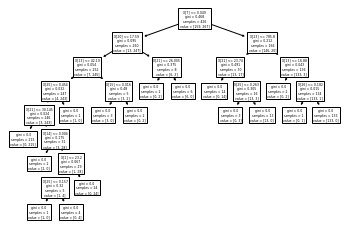

In [9]:
from sklearn.tree import plot_tree

plot_tree(tree_model)

Cóż, niezbyt to ładne ani czytelne (też przez rozmiar)... ale da się lepiej! Wymaga to co prawda trochę roboty i użycia biblioteki Graphviz, ale efekty są tego warte.

### Zadanie 1

Poniżej znajduje się kod tworzący drzewo w formacie .dot (specjalny format opisu grafów) i prawie je renderujący. Prawie, bo brakuje tu pewnych elementów - w końcu fajnie by było mieć nazwy klas i atrybutów na wykresie. W notebooku z pierwszych zajęć pokazałem, jak ładować zbiór danych jako coś więcej niż tylko macierze X i y - jako obiekt Bunch, zawierający więcej danych. Wykorzystaj to tutaj i uzupełnij informacje dla Breast Cancer Wisconsin i narysuj drzewo.

In [10]:
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image, display

# for Windows fans; for others - comment this out, just make sure that everything in Graphviz has is in PATH 
# (can be used from terminal directly)
import os
os.environ["PATH"] += os.pathsep + graphviz_path

In [11]:
dataset = load_breast_cancer()
feature_names = dataset["feature_names"]
target_names = dataset["target_names"]

# write code here!

In [12]:
def export_tree_to_file(tree_model, filename, format):
    dot_data = export_graphviz(tree_model, out_file=None,  # don't save to file yet
                           feature_names=feature_names, # fill this argument!
                           class_names=target_names, # fill this argument!
                           filled=True, rounded=True,  
                           special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.render(filename, format="png")  # here we can choose from many formats
    

def display_tree_from_file(filename):
    display(Image(filename=filename))

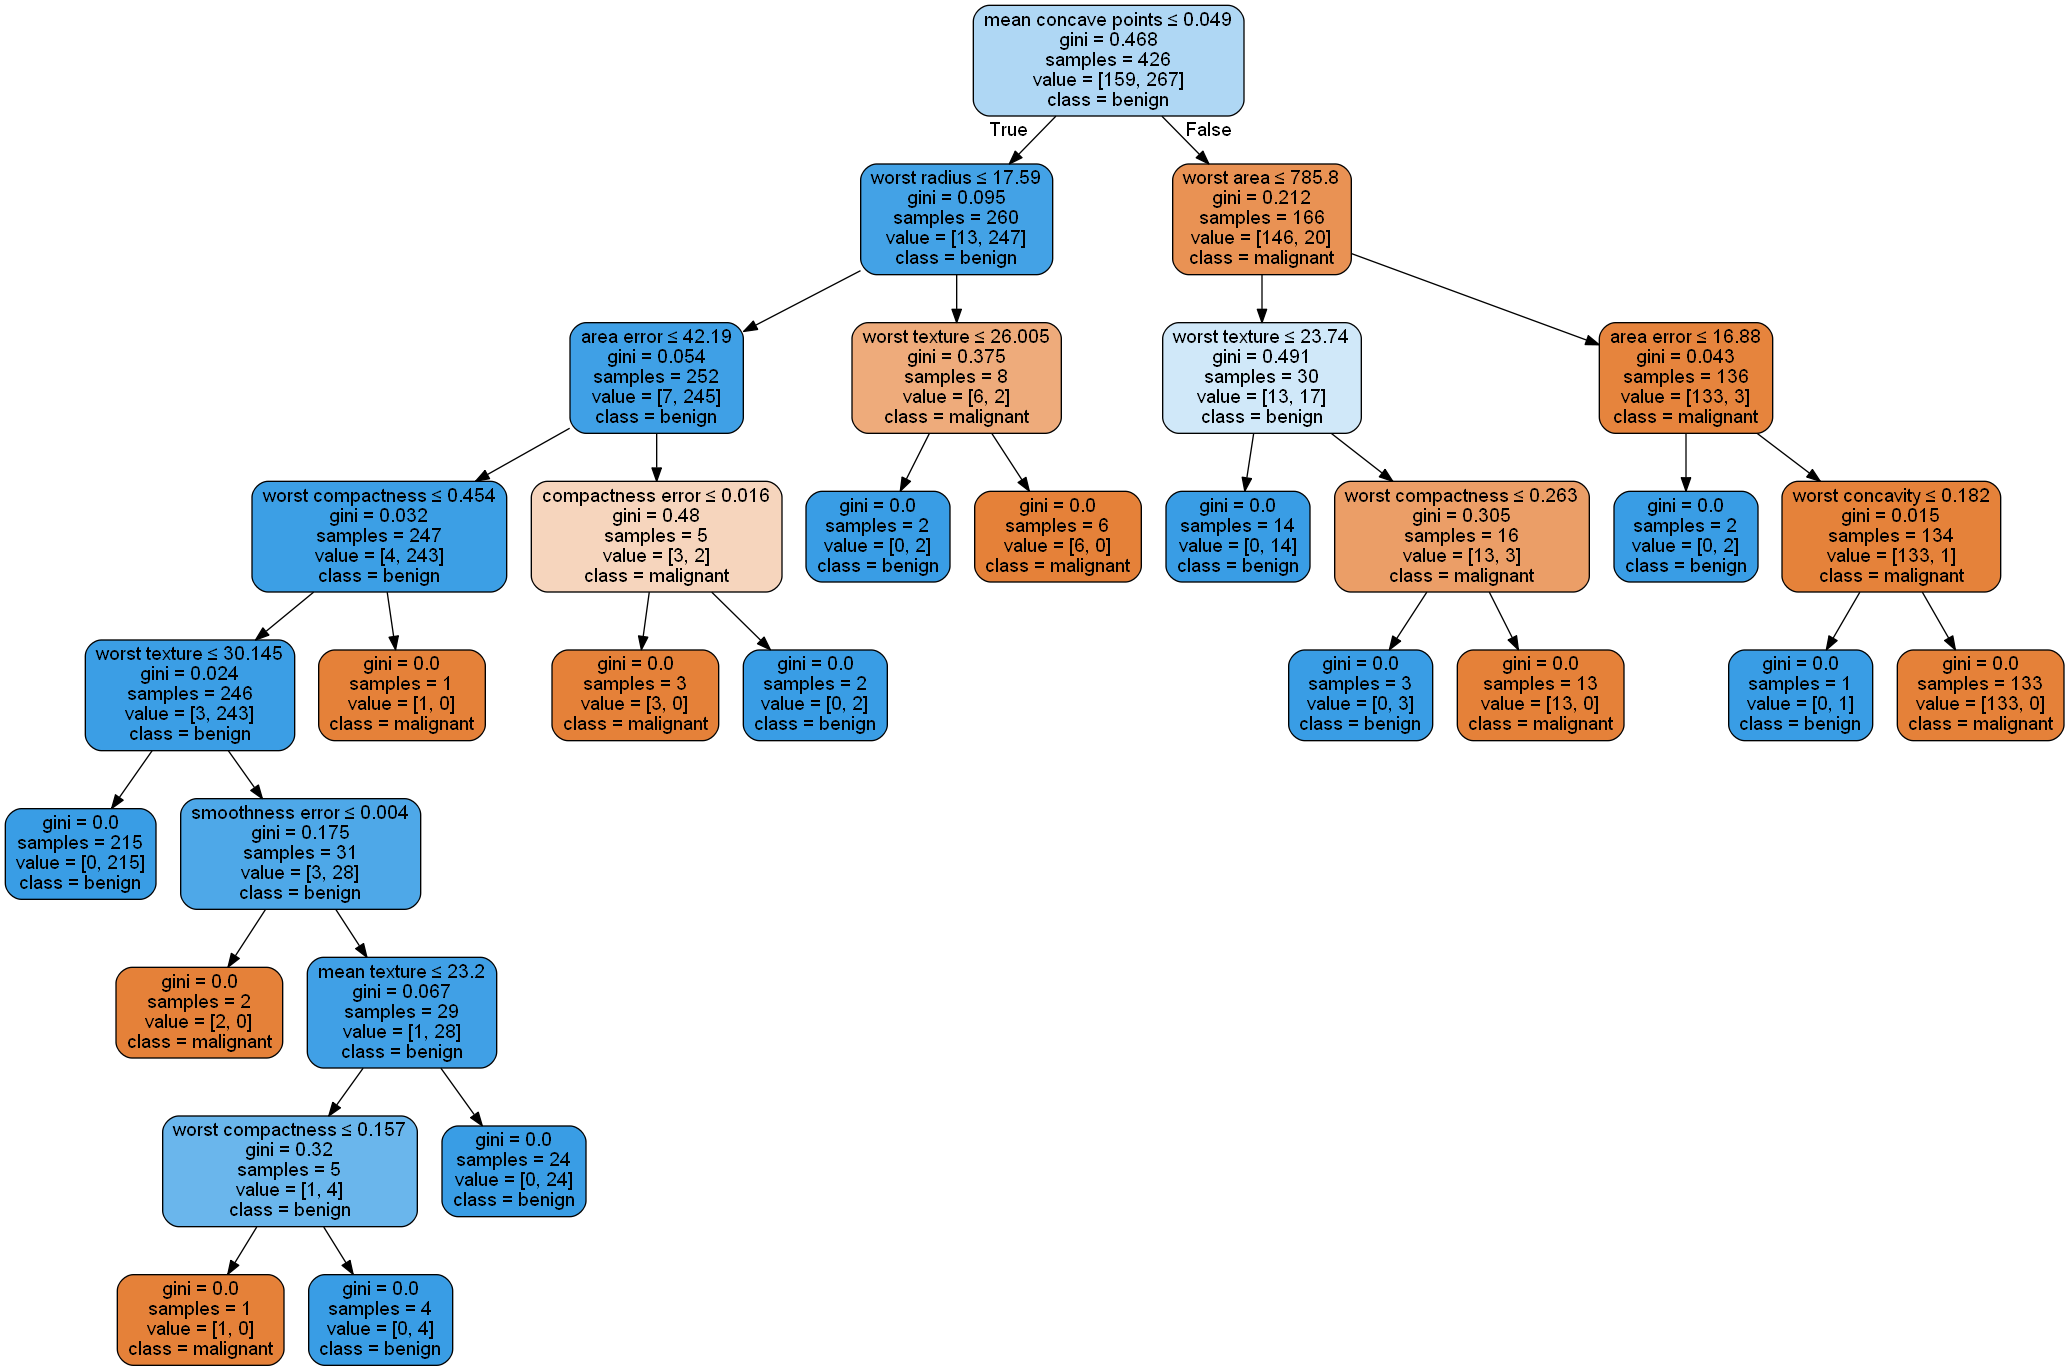

In [13]:
export_tree_to_file(tree_model, "breast_cancer_tree", "png")
display_tree_from_file("breast_cancer_tree.png")

Jak widać, drzewo jest dość potężne. Przy okazji można od razu odczytać, jakie atrybuty zostały uznane przez drzewo za najważniejsze - te, które nie pojawiły się tutaj w ogóle, zdaniem tego klasyfikatora naprawdę niewiele znaczyły. Może jednak dałoby się zrobić mniejsze, trochę przycięte drzewo, które osiągnie lepszy wynik?

## Optymalizacja drzewa

Wykorzystamy walidację skrośną do optymalizacji bodaj najprostszego parametru drzewa, czyli jego maksymalnej głębokości. Sprawdzimy wszystkie możliwe wysokości drzewa od 2 do maksymalnej (wyznaczonej przez klasyfikator bez ograniczenia głębokości, którego użyliśmy wyżej) i wybierzemy najlepszą.

In [14]:
def get_best_tree_depth(X_train, y_train):
    tree_model = DecisionTreeClassifier()
    tree_model.fit(X_train,y_train)
    max_depth = tree_model.get_depth()
    
    best_depth = max_depth
    best_score = cross_val_score(estimator=tree_model, X=X_test, y=y_test, cv=10, scoring='accuracy').mean()
    
    for depth in range(2, max_depth):  # don't check max_depth, since we have it already
        tree_model = DecisionTreeClassifier(max_depth=depth)
        tree_model.fit(X_train, y_train)
        score = cross_val_score(estimator=tree_model, X=X_test, y=y_test, cv=10, scoring='accuracy').mean()
        if score > best_score:
            best_depth = depth
            best_score = score
    
    return best_depth, best_score

In [15]:
for _ in range(10):
    depth, score = get_best_tree_depth(X_train, y_train)
    print("Best tree depth and score:", depth, score)

Best tree depth and score: 5 0.9514285714285714
Best tree depth and score: 4 0.9442857142857143
Best tree depth and score: 6 0.9371428571428572
Best tree depth and score: 2 0.9447619047619048
Best tree depth and score: 3 0.9304761904761906
Best tree depth and score: 8 0.9442857142857143
Best tree depth and score: 4 0.9304761904761906
Best tree depth and score: 5 0.9380952380952381
Best tree depth and score: 2 0.9304761904761906
Best tree depth and score: 6 0.9380952380952381


Co tu się stało? W końcu nasza funkcja miała wyznaczać jedną najlepszą głębokość drzewa? Jest to związane z tym, że drzewa są klasyfikatorem o wysokiej wariancji i nawet przy uśrednieniu dokonanym za pomocą walidacji skrośnej następują pewne wahania, przez które ciężko wyznaczyć jednoznacznie najlepszą głębokość drzewa.

Jak sobie z tym poradzić? Można brać np. głębokość, dla której wynik jest najlepszy (remisy rozwiązując losowo). Zazwyczaj jednak w praktyce nie przejmujemy się tym aż tak bardzo - pamiętajmy, celem ML nie jest tworzenie modeli idealnych, tylko dość dobrych. Dlatego też można po prostu wykorzystać wbudowane funkcje, które obliczą za nas "dość dobre" optymalne wartości parametrów.

### Zadanie 2

Wykorzystaj funkcję `GridSearchCV()` do wyznaczenia optymalnego pod względem głębokości modelu drzewa decyzyjnego. Następnie narysuj z użyciem Graphviz'a to drzewo i porównaj z powyższym. Czy się zmniejszyło? Jak bardzo? Czy daje lepsze wyniki?

Dokumentacja: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
Wyjaśnienie:
- estimator - obiekt klasyfikatora
- param_grid - słownik (dict) mapujący nazwę parametru (np. "max_depth") na listę wartości do sprawdzenia; można tym sprawdzać wiele parametrów, np. jednocześnie "max_depth" i "max_leaf_nodes", ale pamiętając o tym, że liczba punktów do sprawdzenia rośnie wykładniczo (siatka 1D, 2D, 3D, ...)
- scoring - sposób mierzenia jakości
- cv - liczba foldów cross-validation

Na koniec z wyników tej funkcji należy "wyciągnąć" drzewo oraz jego parametry

In [16]:
from sklearn.model_selection import GridSearchCV

In [25]:
def chooseBestTree(X_train, y_train):
    tree_model = DecisionTreeClassifier()
    tree_model.fit(X_train,y_train)
    max_depth = tree_model.get_depth()
    parameters = {'max_dept':list(range(2,max_depth+1))}
    clf = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=parameters, scoring='accuracy', cv = 5)
    print(clf.cv_results)
        
chooseBestTree(X_train, y_train)        
        


AttributeError: 'GridSearchCV' object has no attribute 'cv_results'

## Granice decyzyjne

Dla zbiorów 2D (z 2 cechami) jesteśmy w stanie narysować granicę decyzyjną obliczoną przez drzewo. Zobaczmy, jak będzie się zmieniać granica dla różych wysokości drzew.

Wykorzystamy tutaj sztucznie wygenerowany zbiór "two moons" w kształcie dwóch sierpowatych księżyców.

In [26]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.25, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

In [27]:
def plot_decision_tree_boundary(tree_model, X, y, n_classes, title=""):
    assert X.shape[1] == 2  # ensure that we have exactly 2 features
    
    # get plot boundaries
    sw_min, sw_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # sepal width
    pl_min, pl_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # petal length

    xx, yy = np.meshgrid(np.arange(sw_min, sw_max, 0.01),
                         np.arange(pl_min, pl_max, 0.01))

    Z = tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    fill_colors = ListedColormap(['#a3baff','#fc8b72','#fff38a'])
    cs = plt.contourf(xx, yy, Z, cmap=fill_colors)
    
    point_colors = "bry"  # blue, red, yellow
    for i, color in zip(range(n_classes), point_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)
    
    plt.title(title)
    plt.show()

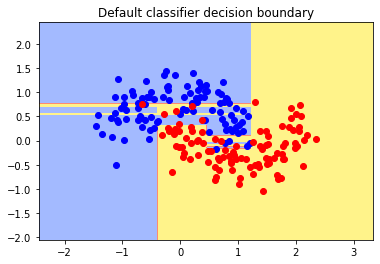

In [28]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

plot_decision_tree_boundary(tree_model, X, y, 3, "Default classifier decision boundary")

Jak widać, mamy bardzo "poszarpaną" granicę decyzyjną, np. niektóre czerwone punkty są "głęboko" w klastrze niebieskich punktów, co mocno zmienia granicę. W końcu powyżej nie ograniczyliśmy głębokości drzewa, stara się ono idealnie dopasować do danych.

### Zadanie 3

Wykorzystując powyższą funkcję, narysuj granice decyzyjne dla różnych maksymalnych głębokości drzewa. Wyznacz maksymalną głębokość drzewa - da się to zrobić w jednej linii. Co można dzięki temu zobaczyć?

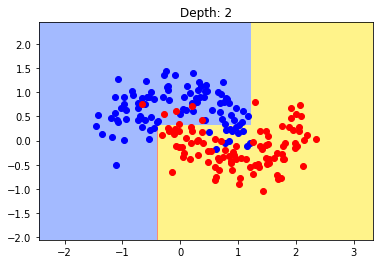

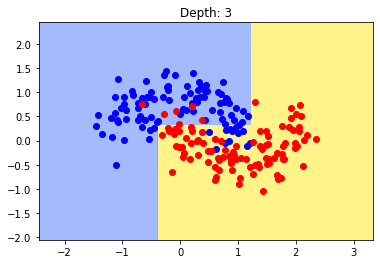

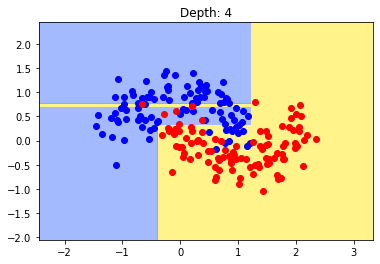

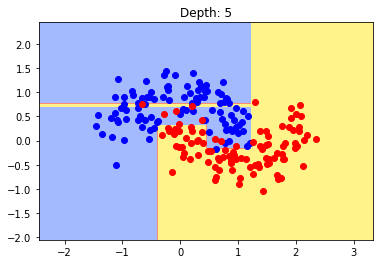

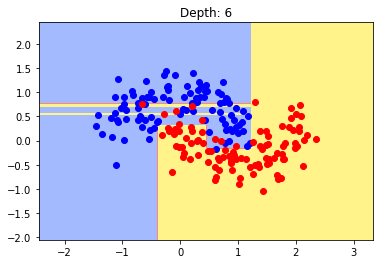

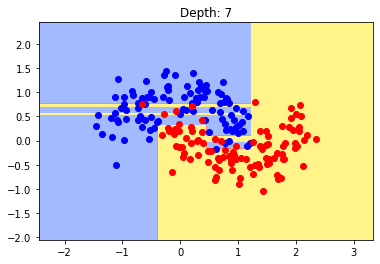

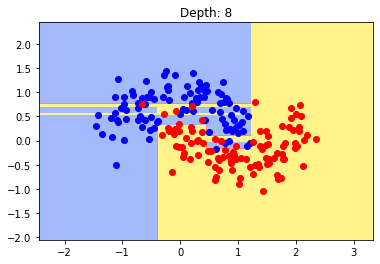

In [29]:
max_depth = tree_model.get_depth()

for depth in range(2, max_depth):
    tree_model = DecisionTreeClassifier(max_depth=depth)
    tree_model.fit(X_train, y_train)
    plot_decision_tree_boundary(tree_model, X, y, 3, f"Depth: {depth}")
    

### Zadanie 4

Jak już wielokrotnie widzieliśmy, drzewa overfittują, co jest konsekwencją tego, że są klasyfikatorem o wysokiej wariancji. Oznacza to też, że są podatne na szum - niewielkie zmiany w danych treningowych powinny widocznie zmieniać drzewo.

Zaimplementuj funkcję `add_noise_to_data(X)`, która zaszumi dane treningowe (testowych nie ruszamy). Można np. zwiększać/zmniejszać losowo wybrane wartości cech o 1-10% (ponownie, wybrane losowo). Dla zbioru Breast Cancer Wisconsin, w którym wszystkie kolumny są liczbowe, dobrze to zadziała.

Dla wybranego podziału na dane treningowe i testowe sprawdź wygląd drzewa na danych czystych i zaszumionych. Jeżeli wygląd drzewa nie zmieni się/zmieni się zbyt bardzo, to odpowiednio zwiększ/zmniejsz poziom zaszumienia. Porównaj także wyniki jakości klasyfikacji na danych testowych.

In [45]:
from random import random

def add_noise_to_data(X):
    noisyX = X[:]
    
    for i in range(len(noisyX)):
        for j in range(len(noisyX[i])):
            noisyX[i][j] *= (1+randint(-10, 10)/100)
            
                
    return noisyX

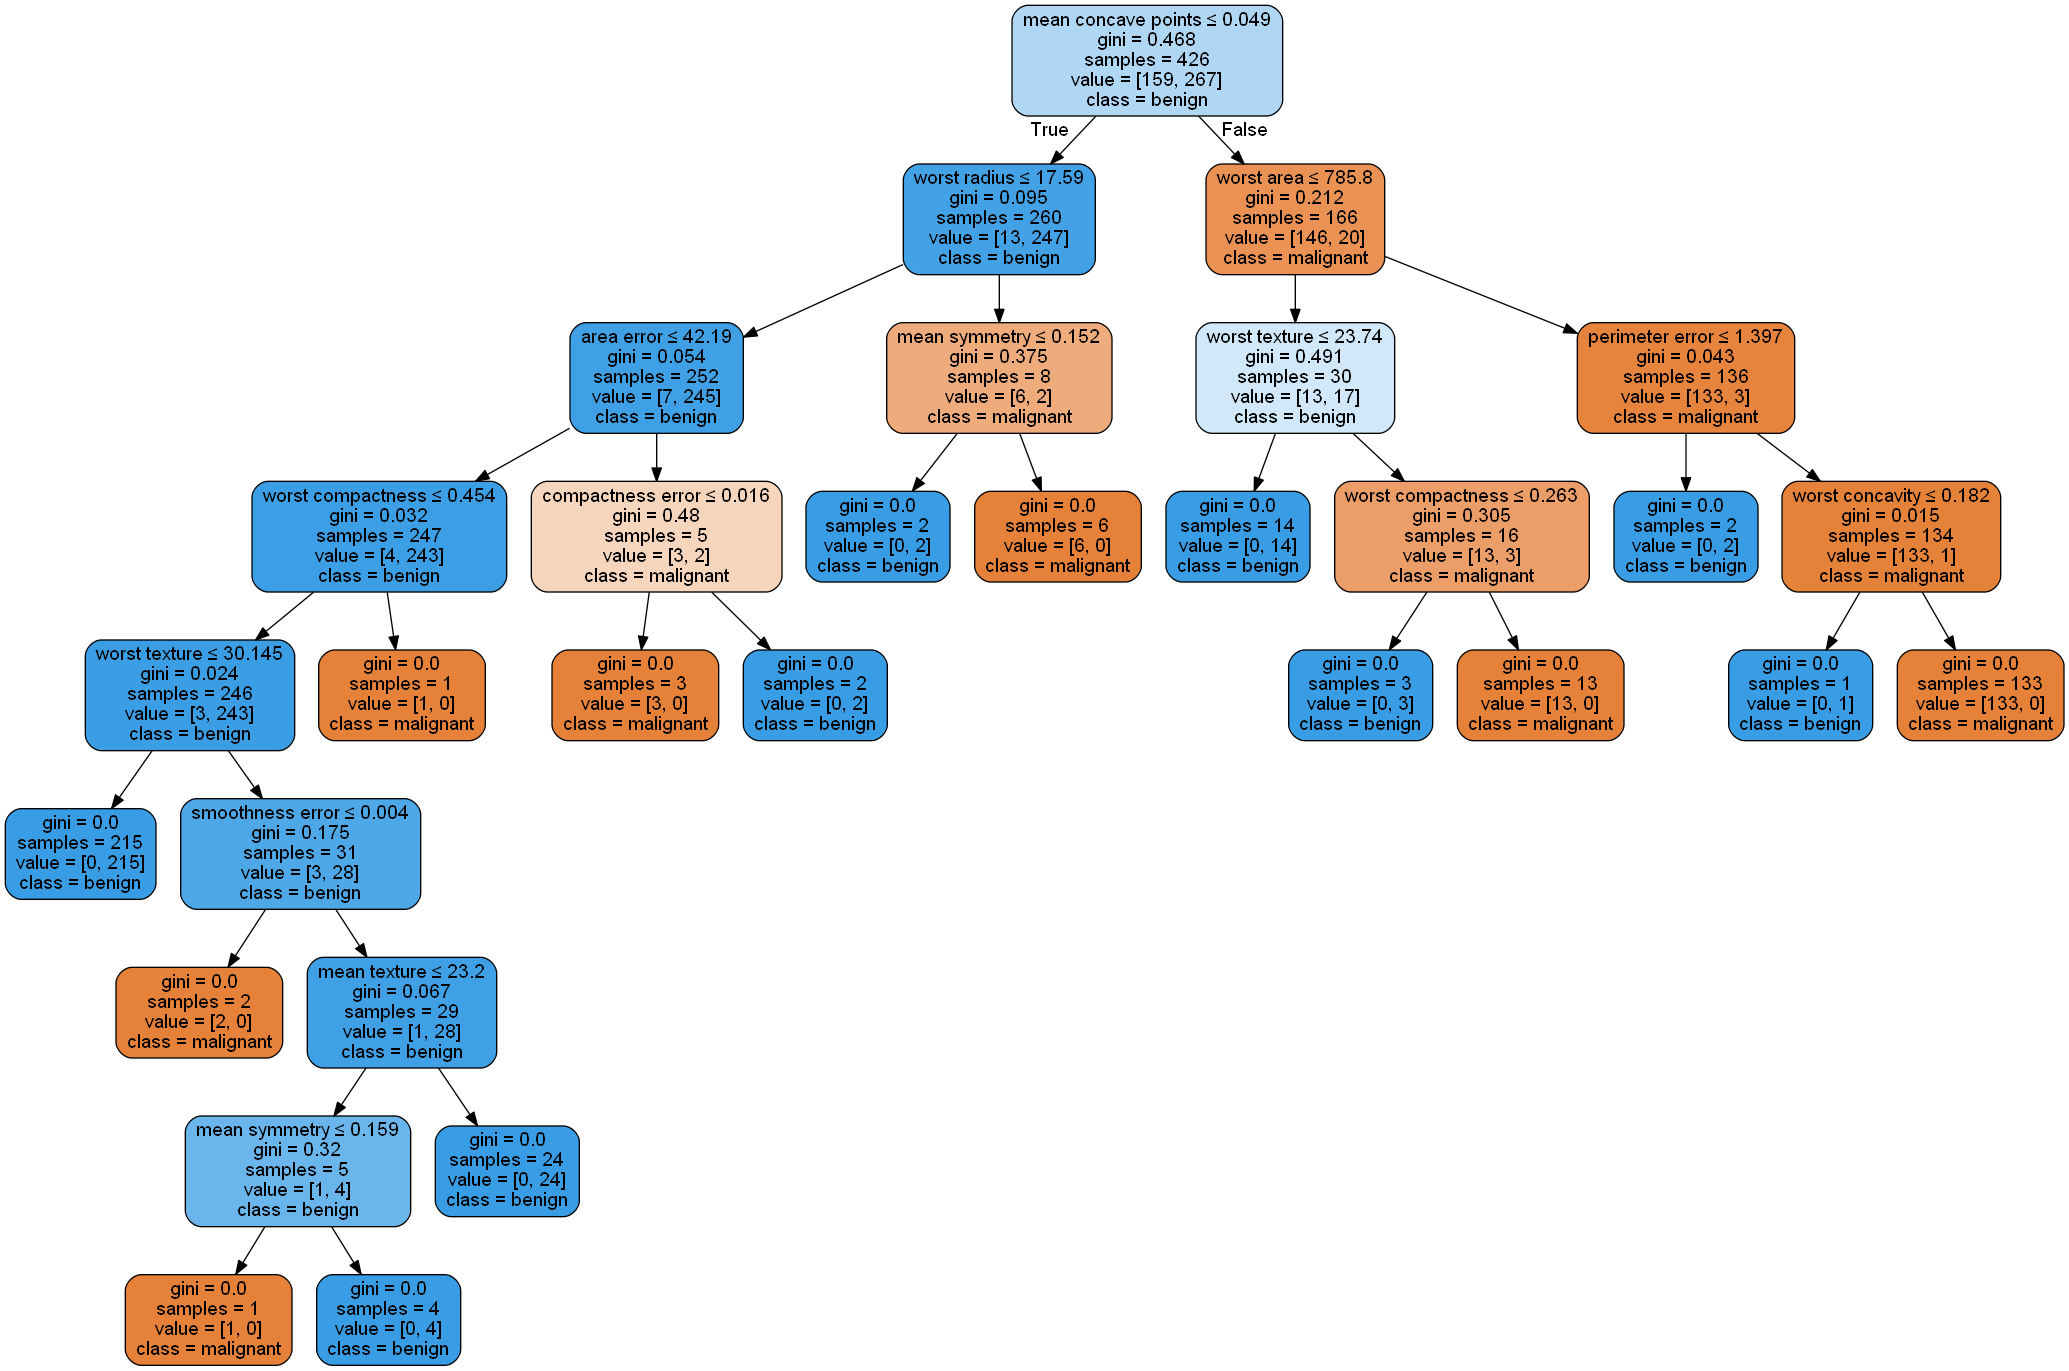

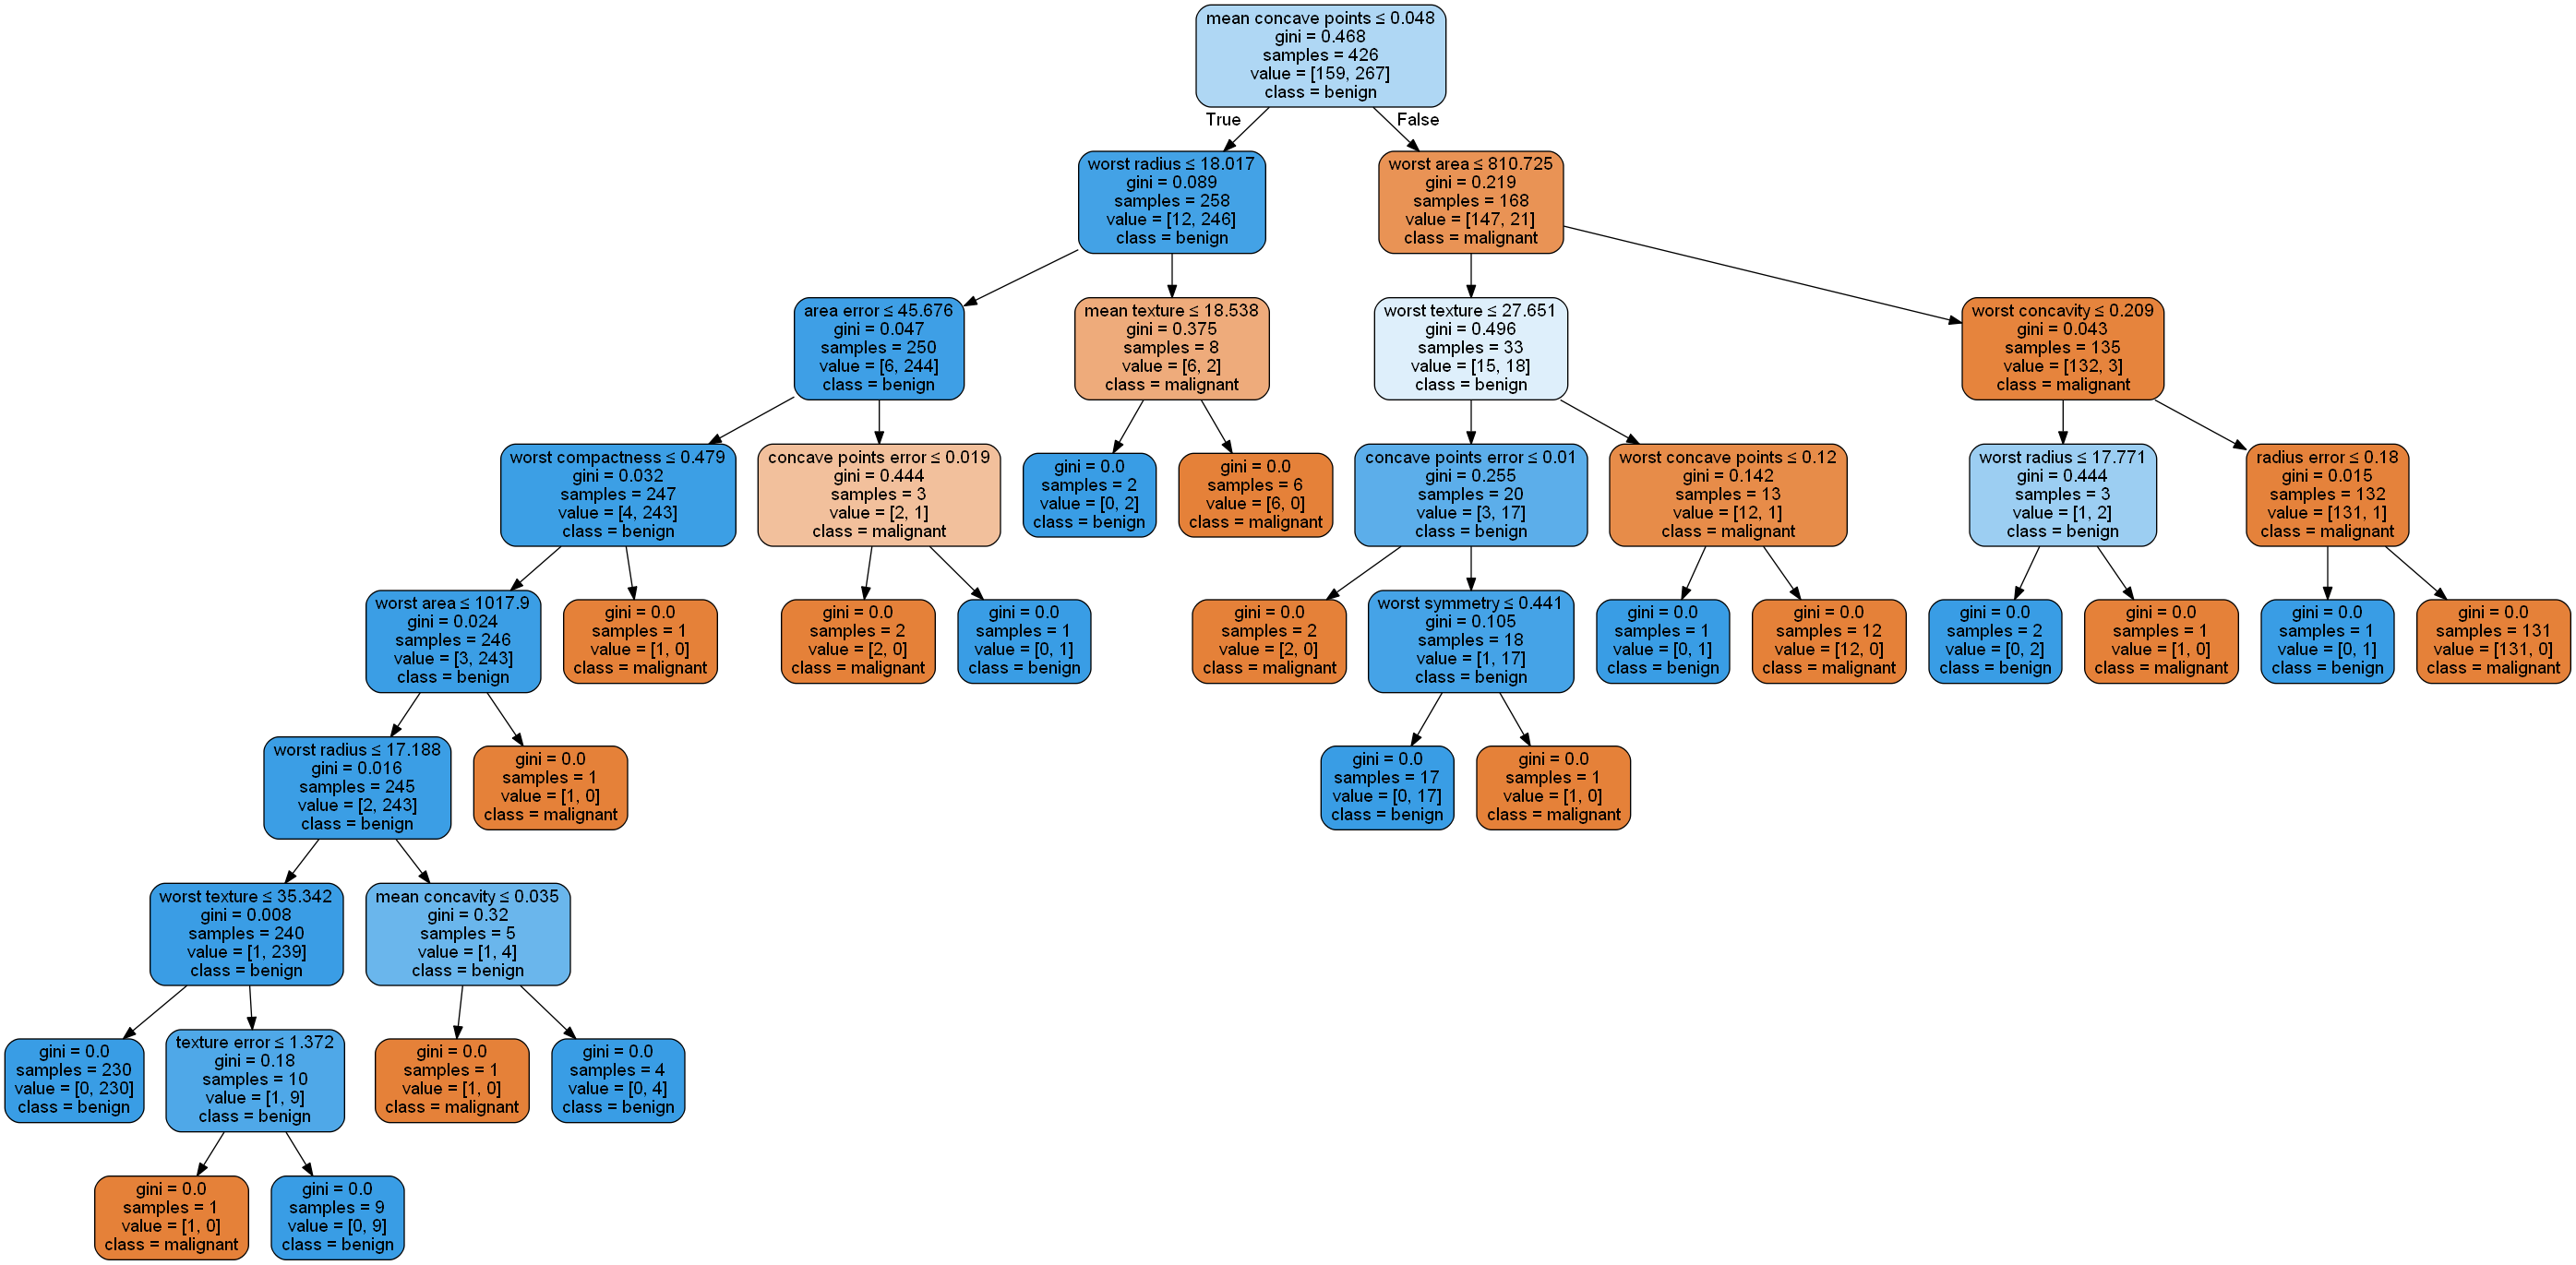

In [46]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)
tree_model_clean = DecisionTreeClassifier()
tree_model_clean.fit(X_train, y_train)
export_tree_to_file(tree_model_clean, "breast_cancer_tree_clean", "png")
display_tree_from_file("breast_cancer_tree_clean.png")

X_noise = add_noise_to_data(X)
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_noise, y, test_size=.25, random_state=0)
tree_model_noise = DecisionTreeClassifier()
tree_model_noise.fit(X_train_noise, y_train_noise)
export_tree_to_file(tree_model_noise, "breast_cancer_tree_noise", "png")
display_tree_from_file("breast_cancer_tree_noise.png")




## Samodzielna implementacja

Zabierzemy się teraz za samodzielną implementację drzewa decyzyjnego krok po kroku.

### Zadanie 5

Zaimplementuj funkcję obliczającą nieczystość Giniego dla grupy sampli X oraz ich klas y.

In [2]:
def countOccurences(y):
    result = {}
    for occur in y:
        if occur in result.keys():
            result[occur] += 1
        else:
            result.setdefault(occur, 1)
    return result


def gini_impurity(X, y):
    n = len(X)
    dictOfOccurences = countOccurences(y)
    p_class = [val / n for key, val in dictOfOccurences.items()]
    impurity = 1
    for val in p_class:
        impurity -= val ** 2

    return impurity

        
    

### Zadanie 6

Zaimplementuj funkcję obliczającą optymalny podział wierzchołka na dzieci dla grupy sampli X oraz ich klas y. Sprawdź w tym celu po kolei wszystkie możliwe atrybuty i punkty podziału - nie musisz jeszcze stosować optymalizacji. Wykorzystaj napisaną wcześniej funkcję `gini_impurity()`.

In [3]:
def split_by_given_threshold(X, y, feature_nr, val):
    X_left, X_right, y_left, y_right = [], [], [], []
    for i in range(len(y)):
        if X[i][feature_nr] <= val:
            X_left.append(X[i])
            y_left.append(y[i])
        else:
            X_right.append(X[i])
            y_right.append(y[i])

    return X_left, X_right, y_left, y_right


def get_best_split(X, y):
    best_imp = gini_impurity(X, y)  # parent impurity
    best_feature = 0
    best_threshold = X[0][0]
    left_child = right_child = None

    for i in range(len(X[0])):
        for j in range(len(X)):
            X_l, X_r, y_l, y_r = split_by_given_threshold(X, y, i, X[j][i])
            left_imp = gini_impurity(X_l, y_l)
            right_imp = gini_impurity(X_r, y_r)
            if best_imp > left_imp + right_imp:
                best_imp = left_imp + right_imp
                best_feature = i
                best_threshold = X[j][i]
                left_child, right_child = (X_l, y_l), (X_r, y_r)

    return best_feature, best_threshold, left_child, right_child,


### Zadanie 7

Funkcje z poprzednich zadań przydadzą się teraz, aby zbudować pełny klasyfikator drzewa decyzyjnego. Powinien on mieć konstruktor oraz wspierać metody `fit()` oraz `predict()`. Przyda się także metoda pomocnicza `_build_tree()`, która będzie budować drzewo. Wykorzystaj zaimplementowane powyżej metody

W Pythonie metody prywatne (tak naprawdę pseudoprywatne, w Pythonie nie ma prawdziwych zmiennych prywatnych) oznacza się zgodnie z konwencją znakiem `_` na początku nazwy (lub końcu, ale to rzadsze).

Aby zbudować samo drzewo, zaimplementuj klasę `TreeNode`. Zauważ, że musi ona trzymać tylko informacje, które będą potrzebne podczas dokonywania predykcji, czyli cechę i próg wartości - same macierze z wektorami wejściowymi trzeba tylko przekazywać rekurencyjnie w funkcji budującej drzewo.

In [4]:
class TreeNode:
    def __init__(self, feature, threshold):
        self.feature = feature
        self.threshold = threshold
        self.category = None
        self.left = None
        self.right = None

In [5]:
class DecisionTree:
    def __init__(self):
        self.root = None

    def _is_pure(self, y):  # are all categories the same?
        for i in range(len(y) - 1):
            if y[i] != y[i + 1]:
                return False
        return True

    def _build_tree(self, X, y):
        feature, threshold, left_child, right_child = get_best_split(X, y)
        newNode = TreeNode(feature, threshold)
        if left_child is not None and right_child is not None and not self._is_pure(y):
            newNode.left, newNode.right = self._build_tree(left_child[0], left_child[1]), \
                                          self._build_tree(right_child[0], right_child[1])
        if self._is_pure(y):
            newNode.category = y[0]

        return newNode

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        y_pred = []
        for vector in X:
            node = self.root
            while node.left is not None and node.right is not None:
                if vector[node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            y_pred.append(node.category)
        return y_pred

    def inOrder(self, root, level=0):
        if root is None:
            return
        self.inOrder(root.left, level + 1)
        print(root.category, level)
        self.inOrder(root.right, level + 1)

### Zadanie 8

Przetestuj stworzone przez siebie drzewo oraz porównaj je z gotowym drzewem ze Scikit-learn. Wykorzystaj do tego zbiór Divorce Predictors Dataset, który jest na dysku obok tego notebooka. Aby załadować plik .csv, wykorzytaj bibliotekę Pandas. Pozwala ona łatwo dostać się do atrybutu dzięki wykorzystaniu Dataframe'ów - działają jak słowniki. Przyda się tutaj metoda `.pop()`, która pozwoli łatwo podzielić plik na atrybuty i klasę.  
Przydatny tutorial: https://www.geeksforgeeks.org/python-pandas-dataframe-pop/

Divorce Predictors Dataset został stworzony na podstawie ankiet dla małżeństw, w których mieli udzielić odpowiedzi w skali od 0 do 4 - są to więc tylko atrybuty kategotyczne, jest ich 54. Kolumna "Class" to klasa - 1, jeżeli małżeństwo skończyło się rozwodem lub 0, jeżeli rozwód nie nastąpił. Dokładny opis: https://archive.ics.uci.edu/ml/datasets/Divorce+Predictors+data+set

Uwaga: jeżeli przewidujesz potrzebę skorzystania z klasyfikatora dla tego zbioru, to poczekaj, aż wykorzystamy wiele drzew w ensemble learningu. Zobaczysz, że lasy losowe poradzą sobie o wiele lepiej i pewniej!  
Kwestia tego, czemu lasy znają się lepiej od drzew na rozwodach - do samodzielnego przemyślenia.

In [6]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



data = pd.read_csv("divorce_dataset.csv", sep=';')
y = list(data.pop("Class"))
X = data.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_tree_pred = tree_model.predict(X_test)

my_tree = DecisionTree()
my_tree.fit(X_train, y_train)
y_my_tree_pred = my_tree.predict(X_test)

print("Default decision tree results:")
print(classification_report(y_test, y_tree_pred))

print("My tree predictions:")
print(classification_report(y_test, y_my_tree_pred))

my_tree.inOrder(my_tree.root)

Default decision tree results:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.95      0.90      0.93        21

    accuracy                           0.93        43
   macro avg       0.93      0.93      0.93        43
weighted avg       0.93      0.93      0.93        43

My tree predictions:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.95      0.90      0.93        21

    accuracy                           0.93        43
   macro avg       0.93      0.93      0.93        43
weighted avg       0.93      0.93      0.93        43

0 2
None 1
1 2
None 0
1 1


## Jeszcze więcej drzew decyzyjnych?

Jeżeli masz siły i chęci, to jest jeszcze całkiem sporo ulepszeń, które można wprowadzić do tego drzewa decyzyjnego:
- wykorzystanie bardziej optymalnego sposobu liczenia podziału, aby zmniejszyć złożoność
- możesz zastanowić się, jak odróżnić zmienne logiczne, kategoryczne i liczbowe - nie jest to proste, ale można sporo zyskać, bo podział dla zmiennych logicznych i kategorycznych można o wiele szybciej policzyć
- dodaj pre-pruning do swojego klasyfikatora, np. w postaci funkcji max_depth (prosto zaimplementować w rekurencji) lub min_leaf_size (trzeba sprawdzać `.shape[0]` dla dzieci)
- dodaj funkcję `export_to_dot`, która eksportuje graf do pliku zgodnie z formatem .dot (https://en.wikipedia.org/wiki/DOT_(graph_description_language)) - dzięki temu będzie można wizualizować te drzewa Graphviz'em
- dodaj możliwość liczenia nie tylko nieczystości Giniego, ale także entropii, jak w drzewach C4.5